# ML 3 -- See in the Data

In [ ]:
%matplotlib inline
import pandas as pd
from string import atoi,atof
import seaborn as sns

In [3]:
dataframe=pd.read_hdf('data/after_ML1.h5','houseofparis_2')
clear_floor = lambda x: x if x<10 else -1
def clear_dist(x):
    try:
        return atoi(str(x))
    except Exception,m:
#         print m,x
        return -2
dataframe.floor=dataframe.floor.apply(clear_floor)
dataframe.district = dataframe.district.apply(clear_dist)

## The dataframe
In the dataframe we have the following features

In [4]:
dataframe.columns

Index([             u'ins date',                   u'idx',
                         u'url',                   u'sqm',
                       u'price',                 u'floor',
                         u'loc',                 u'metro',
                    u'district',               u'date in',
                     u'text in',             u'furnished',
                  u'no smoking',           u'w/d hookups',
         u'dogs are OK - wooof',           u'w/d in unit',
       u'wheelchair accessible',                 u'title',
                        u'desc',       u'district_binary',
                   u'price_bin',               u'sqm_bin',
                   u'price_sqm',               u'laundry',
                        u'type',               u'parking',
             u'predicted_floor',     u'predicted_parking'],
      dtype='object')

## Distribution of flats per floors per district

I think that this is representative of the current dataset only.

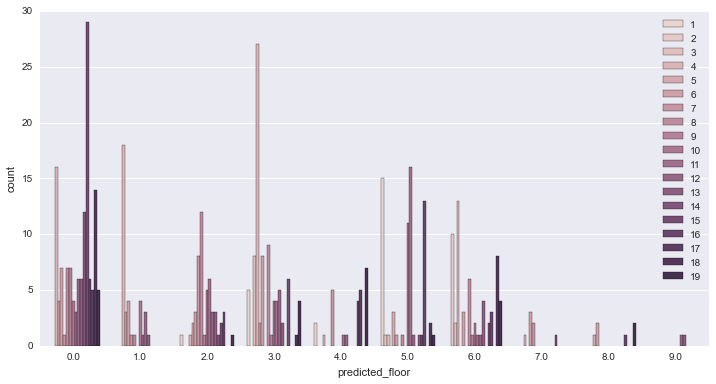

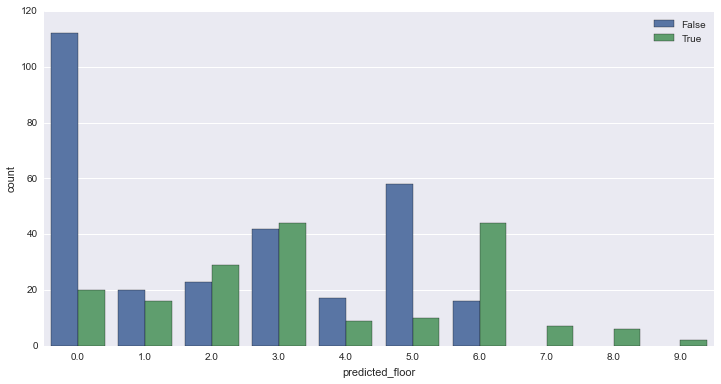

In [3]:
_=sns.countplot(data=dataframe[dataframe.district>0],x='predicted_floor',hue='district',
                palette=sns.cubehelix_palette(n_colors=21))
_.legend(loc=1)
fig = _.figure
fig.set_size_inches(12,6)

sns.plt.figure()
_=sns.countplot(data=dataframe[dataframe.district>0],x='predicted_floor',hue='furnished')
_.legend(loc=1)
fig = _.figure
fig.set_size_inches(12,6)

## Principal Components Analysis

PCA will tell us of linear combinations of features that orthoganilize the data [see wiki]

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

About the selected fields:
1. Metro obviously correlates with district, so I choose disctrict

We normalize the input features with the default ``Normalizer`` and then ``fit-transform`` via PCA with 3 components.
The ``fit-transform`` is a ``scikit-learn`` way to keep a common API among the ML models. PCA does not really fits the data. See this [] and this [] and withening transformation [wiki]

In [9]:
X = dataframe[['price_bin',
               'district',
               'sqm_bin',
               'furnished',
               'price_sqm',
               'predicted_floor']][ (dataframe.district>0) ]
normalizer = Normalizer()
Xa = normalizer.fit_transform(sns.np.array(X).astype('float'))
pca = PCA(n_components=3)
pca.fit(Xa)
X_r = pca.transform(Xa)

The cool thing of PCA is that we can actually _see_ the component/eigenmodes, that are the linear combinations of features that form the basis of the transformation. By choosing $N=3 < N_\text{features}$ we are effectively reducing the number of d.o.f. of the dataset, the amount of information lost is given in the 2nd plot. The first 3 components hold 97% of the information, so the remaining 3 modes hold only 3%.

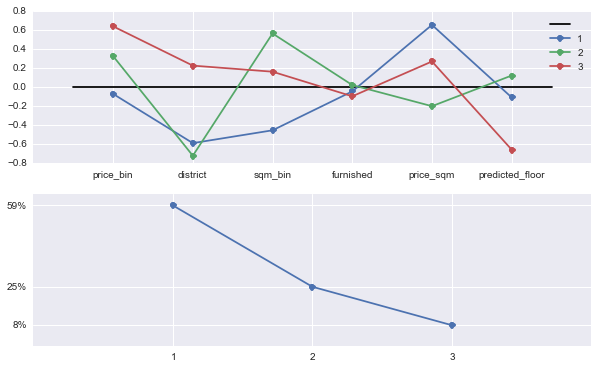

In [6]:
cols = X.columns
ncols = len(cols)
modes = pca.explained_variance_ratio_
nmodes = len(modes)
f,(ax,bx)=sns.plt.subplots(2,1,figsize=[10,6])
ax.plot([-.5,ncols-.5],[0,0],'-k')

ax.plot(pca.components_.T,'-o')
ax.xaxis.set_ticks(range(ncols))
ax.xaxis.set_ticklabels(cols)
ax.set_xlim(-1,ncols)
_=ax.legend(' 123')

bx.plot(range(1,nmodes+1),pca.explained_variance_ratio_*100,'-o')
bx.set_xlim(0,nmodes+1)
bx.xaxis.set_ticks(range(1,nmodes+1))
bx.yaxis.set_ticks(pca.explained_variance_ratio_*100)
bx.yaxis.set_ticklabels(['%d%%'%j for j in pca.explained_variance_ratio_*100]);
bx.set_ylim(0,65);

### Comments

* The first, second, and third modes hold, respectively, 59%, 25%, and 8% of the total signal. Thus the rest is essentially _ado about nothing_
* The _first mode_ captures the strong correlation between `district` and flat size `sqm_bin`, and the correlation between _size_ and _price per sqm_. Well, I hoped to see it, there is still hope to find a good flat, then
* The field `furnished`, is essentialy uncorrelated to the rest of the data. We will see that this is not really the case, but `PCA` has nothing more to say about it.
* For the first two modes the ``predicted_floor`` is also, essentially, unimportant. 


We can visualize better these finding by projecting the dataset over just two modes (that can be plotted), coloring each point by the  value of the feature in that point. 
A bit of code will clarify what I mean:

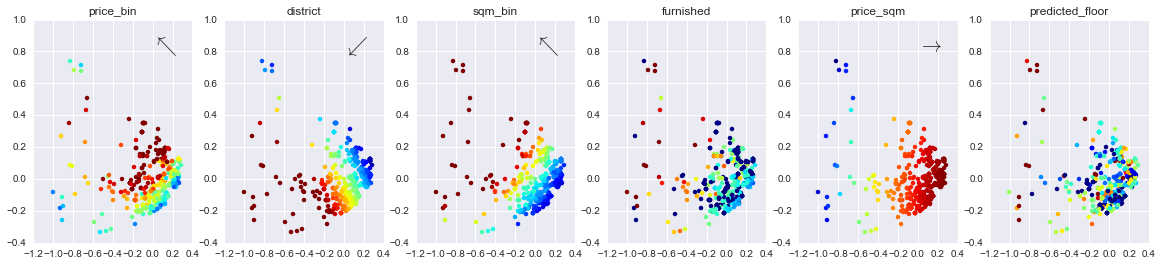

In [38]:
import numpy as np
import scipy.interpolate as interp

cols = X.columns
clrs = len(cols)

fig,axs = sns.plt.subplots(1,clrs,figsize=(20,4))

(xdense,ydense) = np.mgrid[X_r[:,0].min():X_r[:,0].max():20j,X_r[:,1].min():X_r[:,1].max():20j,]
x_sparse,y_sparse,_ = X_r.T
arrows = (j for j in (r'$\nwarrow$', r'$\swarrow$',r'$\nwarrow$',0,r'$\rightarrow$',0))
for clr in xrange(clrs):
    ax = axs[clr]
    if cols[clr]!='price_sqm':
        mp = sns.np.std(Xa[:,clr])*3. # outside 3sigma is 
    else:
        mp = sns.np.max(Xa[:,clr]) 
    
    for i,j in enumerate(X_r):
        
        df=Xa[i]
        if df[clr]>=0: #  Because <0 means no-data
            ax.scatter(j[0],j[1],c=sns.plt.cm.jet((df[clr]/mp)),lw=0)
    z_sparse = Xa[:,clr]
    z_dense = interp.griddata((x_sparse,y_sparse),z_sparse,(xdense,ydense))
    
#     ax.imshow(z_dense,extent=[xdense.min(),xdense.max(),ydense.min(),ydense.max()],
#              cmap=sns.plt.cm.jet,aspect = 'auto', origin = 'bottom')
    arr = arrows.next()
    if arr:
        ax.text(0,.8,arr,fontsize=20)
    
    ax.set_title(cols[clr])
    

### Comments

Coloring the points with the value of each feature highlights the mutual relations. Some of them are trivial, like  between `price_bin` and `sqm_bin`, but `PCA` simplified the relation with the districts showing that, expectedly, some are systematically more expensive than others.  The feature `price_sqm` is "parallel" to the first component. This means that, as we move along the x-axis we go from inexpensive (per sqm) to expensive flats. However, each feature has a somewhat different gradient direction. For example, it seems that the `price_sqm` levels off for somewhat small flats in _low_ districts (??). We should start by checking this last relation.


## Digging into the suggested correlations

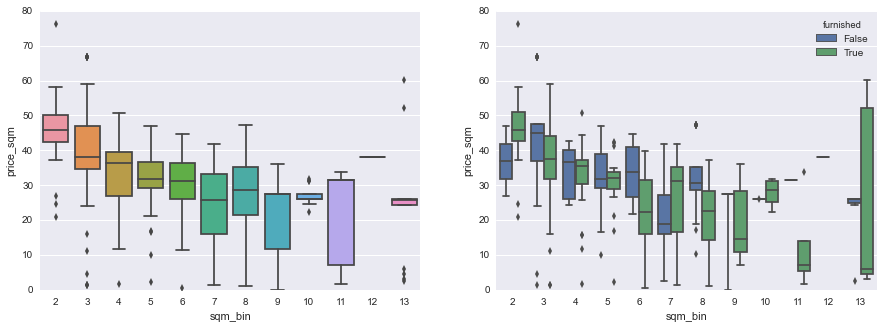

In [39]:
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='sqm_bin',y='price_sqm',data=X,ax=ax)
sns.boxplot(x='sqm_bin',y='price_sqm',data=X,hue='furnished',ax=bx);

As predicted by PCA, ``price_bin`` and ``sqm_bin`` are anti correlated. What PCA could not predict is that the correlation is not linear, the price per sqm levels at bin 20. **NOTA BENE**: this and the previous and the following plots show that the data is not reliable for every slice (eg: `sqm_bin` >9)

In [93]:
sorted_district_by_aveprice = []
__tmp = []
for c in X.groupby('district'):
    __tmp.append((c[0],c[1].price_sqm.mean()))
import numpy as np
__tmp = np.asarray(__tmp)
__sidx = np.argsort(__tmp[:,1])
sorted_district_by_aveprice = __tmp[__sidx][:,0]
sorted_district_by_aveprice_labels = ['%d'%j for j in sorted_district_by_aveprice]

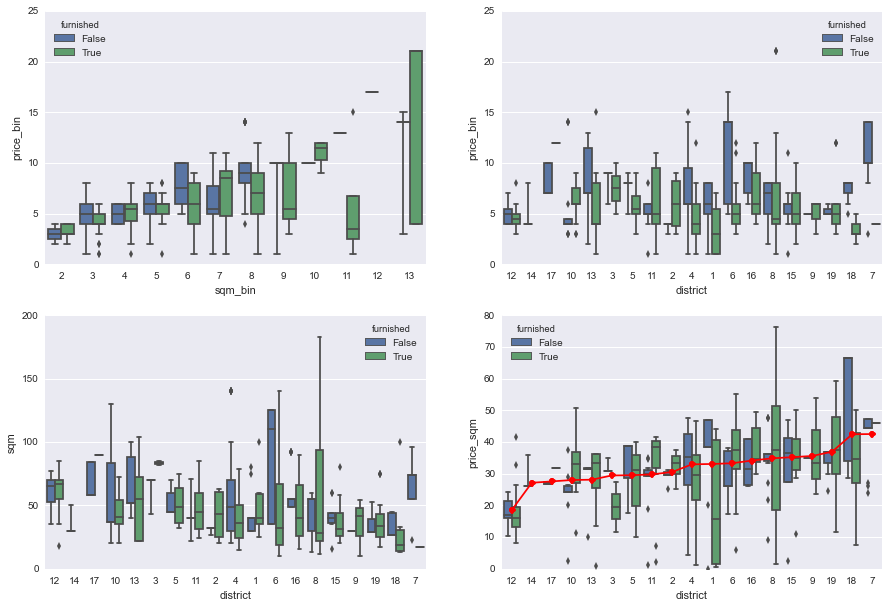

In [94]:
f ,((ax,bx),(cx,dx)) = sns.plt.subplots(2,2,figsize=(15,10))
Xfld = 'price_bin'
sns.boxplot(y=Xfld, x="sqm_bin", hue = "furnished",data=X,ax=ax);
sns.boxplot(y=Xfld, x="district", hue = "furnished",data=X,ax=bx,order = sorted_district_by_aveprice)
sns.boxplot(y="sqm", x="district", hue = "furnished",data=dataframe,ax=cx,order = sorted_district_by_aveprice)
sns.boxplot(y='price_sqm', x="district", hue = "furnished",data=X,ax=dx,order = sorted_district_by_aveprice)
dx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
cx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
bx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
dx.plot(__tmp[__sidx][:,1],'r-o')
cx.set_ylim(0,200);

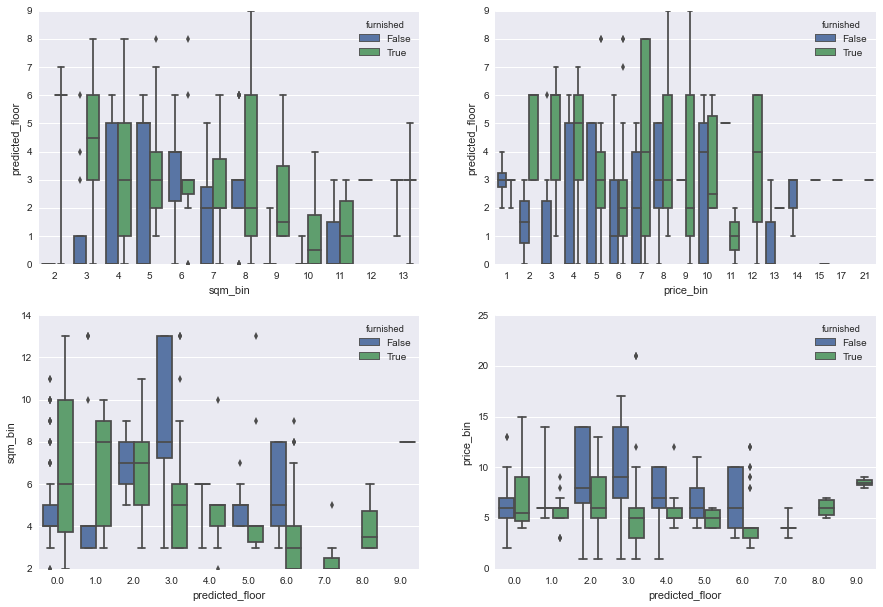

In [109]:
f ,((ax,bx),(cx,dx)) = sns.plt.subplots(2,2,figsize=(15,10))
Xfld = 'predicted_floor'
sns.boxplot(y=Xfld, x="sqm_bin", hue = "furnished",data=X,ax=ax);
sns.boxplot(y=Xfld, x="price_bin", hue = "furnished",data=X,ax=bx)
sns.boxplot(x=Xfld, y="sqm_bin", hue = "furnished",data=X,ax=cx);
sns.boxplot(x=Xfld, y="price_bin", hue = "furnished",data=X,ax=dx);

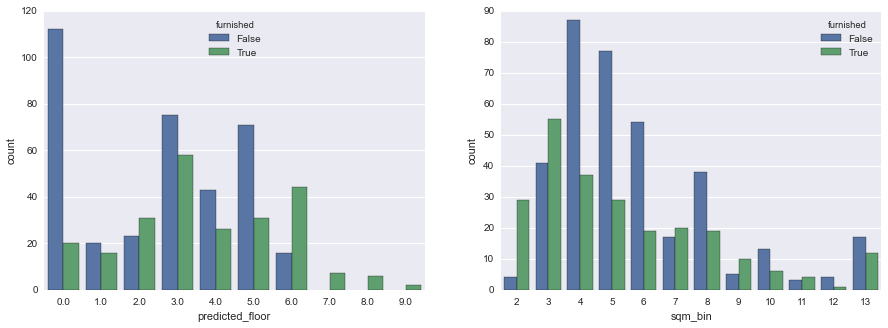

In [111]:
fig,(ax,bx) = sns.plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='predicted_floor',hue='furnished',data=dataframe,ax=ax)
sns.countplot(x='sqm_bin',hue='furnished',data=dataframe,ax=bx)

## Geographical plots
TODO

In [112]:
from IPython.display import Image 
Image(url='https://upload.wikimedia.org/wikipedia/commons/6/65/Arrondissements-de-Paris.png')

## Finally




* Some columns in dataframe are quite empty and/or not statistically relevant (eg. floor). We will try to fill them with a ML technique
* We did not plot any geographical representation. This is TD

In [17]:
from IPython.display import HTML
import urllib2

style=open('style.css','r').read()
HTML("""
<style>{0}</style>
""".format(style))